# **Final section and model training**

The final phase of this project.

**Objectives**
- Optimize the value of L (number of previous characters) for best model performance
- Explore computing constraints (in this assignment, by a constraint of total duration just under 2 hours). Decide on which parameters to increase to optimize performance while ensuring total training time is under 2 hours.
- Train the final model on the full training data. Report the accuracy of predictions of the last token on the test data

### **Importing**

In [ ]:
# Import all modules and functions
import scripts.functions as functions
from functions import *

In [ ]:
# Import train and test sets
train_text_int = np.load("train_text_int.npy")
test_text_int = np.load("test_text_int.npy")

# For model tuning, separate train_text_int into training and validation sets
print(len(train_text_int))

# 1/9 of the training set will be used for validation
val_text_int = train_text_int[-10_000_000:]
training_text_int = train_text_int[:80_000_000]
print(len(val_text_int))
print(len(training_text_int))

90000000
10000000
80000000


In [ ]:
# Import model
import models.transformer_III as intermediate_transformer

In [ ]:
# a single gradient update
def train_step(params, opt_state, x, y, tx):
    """
    Args:
      params: pytree of model parameters.
      opt_state: optax optimizer state corresponding to `params`.
      x: (B_seq, B_tok) int array input tokens.
      y: (B_seq, B_tok) int array target tokens.
      tx: optax.GradientTransformation (already initialized).

    Returns:
      new_params: updated parameters after one gradient step.
      new_opt_state: updated optimizer state.
      metrics: dict of scalar metrics (loss, acc).
    """
    def loss_fn(params):
        logits = model.apply({"params": params}, x)
        loss, metrics = loss_and_metrics(logits, y)
        return loss, metrics

    # compute gradients of loss w.r.t params (loss is scalar, metrics is auxiliary)
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # optax update: update params and new optimizer state
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics

# jit: last argument should be static because it is an object
train_step = jax.jit(train_step, static_argnames=("tx",))

In [ ]:
import yaml

with open("./conf/config4.yml", "r") as f:
    cfg = yaml.safe_load(f)
    print(cfg)

# model parameters
vocab_size = cfg['vocab_size']
d_model = cfg['d_model']
n_layers = cfg['n_layers']
n_heads = cfg['n_heads']
max_len = cfg['max_len']
activation = cfg['activation']
mlp_ratio = cfg['mlp_ratio']
dropout = cfg['dropout']

# hyperparameter
lr = cfg['learning_rate']

{'vocab_size': 27, 'd_model': 256, 'n_layers': 4, 'n_heads': 8, 'max_len': 128, 'activation': 'GeLU', 'mlp_ratio': 4, 'dropout': 0.2, 'learning_rate': 0.0001, 'weight_decay': [0.01, 0.001, 0.0001], 'gradient_clipping': [0.1, 0.5, 1.0, 2.0], 'adapt_grad_clipping': [0.01, 0.1, 0.5, 1.0]}


In [ ]:
# Initialize the model architecture and params
def create_train_state(key, vocab_size, d_model, n_layers, n_heads, max_len, activation, mlp_ratio, dropout):
    model = intermediate_transformer.DecoderOnlyTransformer(vocab_size, d_model, n_layers, n_heads, max_len, activation, mlp_ratio, dropout)

    # Create dummy input for initialization of batch size 1, seq length min(16, max_len)
    dummy = jnp.zeros((1, min(16, max_len)), dtype=jnp.int32)
    # Initialize the parameters and extracts the PyTree of params
    params = model.init({"params": key}, dummy)["params"]
    return model, params

In [ ]:
# Warmup
warmup = optax.linear_schedule(
    init_value = 0.0,
    end_value = lr,
    transition_steps = 1_000
    )

# cosine decay after warmup
cos_decay = optax.cosine_decay_schedule(
    init_value = lr,
    decay_steps=20_000,
    alpha = 0.0
    )

schedule = optax.join_schedules(
    schedules=[warmup, cos_decay],
    boundaries=[1_000]
    )

tx = optax.chain(
    optax.clip_by_global_norm(0.5),
    optax.lion(learning_rate = schedule)
    )

### **Optimizing L (Phase 1)**

The main objective of this project is to predict the most likely next character given the previous L characters.

What are we optimizing on? In creating batches of samples from the training data, each training sample in one batch is a sequence of T tokens long. While training, the model is given T characters and asked to predict the next character at each position.

Model performance may improve if the model is conditioned on a longer sequence of previous characters (by increasing `B_tok`, or T). However, this could lead to an increase in training time.

Many experiments ago, a rather simple model with sinusoidal P.E is experimented with different sequence lengths used in a batch, to check if sinusoidal P.E does generalize the model better to longer sequence lengths.

Experiment with different sequence lengths here.

In [ ]:
T = [32, 48, 64, 80]

In [ ]:
# Keep track of all results
val_loss_all = []
val_time_all = []

for t in T:
    # Initialize the model architecture and params
    model, params = create_train_state(key, vocab_size, d_model, n_layers,
                                       n_heads, max_len, activation, mlp_ratio, dropout
                                       )

    # Initialize optimizer state for current params
    opt_state = tx.init(params)
    niter = 20_000
    B_seq, B_tok = 64, t
    print(f"Testing with {t} sequence lengths")

    time_val_history = []
    loss_val_history = []
    time_start = time.time()
    for it in range(niter):
        batch = get_batch(training_text_int, B_seq, B_tok)
        input, target = batch[0], batch[1]
        params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx)

        # update model weights and optimizer state
        params = params_new
        opt_state = opt_state_new

        # Evaluate on validation data periodically
        if it % (niter // 50) == 0 or it == niter - 1:
            time_since_start = time.time() - time_start
            # compute loss on validation set
            B_val, T_val = 1024, 32
            val_batch = get_batch(val_text_int, B_val, T_val)
            val_input, val_target = val_batch[0], val_batch[1]
            val_logits = model.apply({"params": params}, val_input)
            val_loss, val_metrics = loss_and_metrics(val_logits, val_target)
            loss_val_history.append(val_loss)
            time_val_history.append(time_since_start)

    val_loss_all.append(loss_val_history)
    val_time_all.append(time_val_history)

Testing with 32 sequence lengths
Testing with 48 sequence lengths
Testing with 64 sequence lengths
Testing with 80 sequence lengths


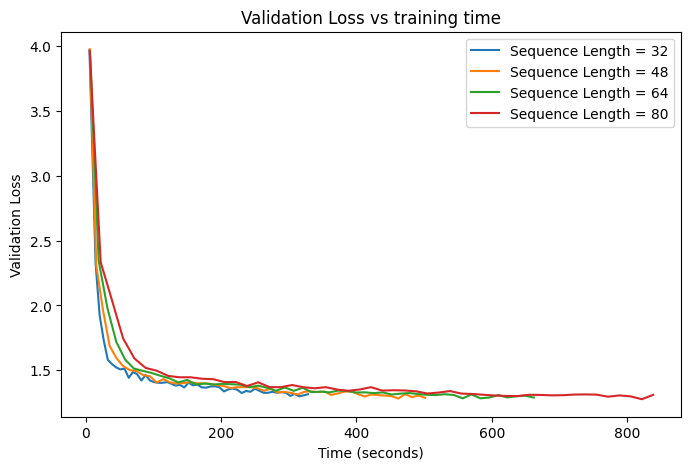

In [ ]:
plt.figure(figsize=(8,5))

for i in range(0, len(T)):
    plt.plot(val_time_all[i], val_loss_all[i], label = f"Sequence Length = {T[i]}")

plt.xlabel("Time (seconds)")
plt.ylabel("Validation Loss")
plt.title("Validation Loss vs training time")
plt.legend(loc='upper right')

plt.show()

In [ ]:
for i in range(0, len(T)):
    string = f"""
    Trained on sequence lengths of {T[i]}:
    Final validation loss: {val_loss_all[i][-1]}
    Total Training Time: {val_time_all[i][-1]}
    Minimum validation loss: {min(val_loss_all[i])} attained at {val_time_all[i][val_loss_all[i].index(min(val_loss_all[i]))]} seconds
    """
    print(string)


    Trained on sequence lengths of 32:
    Final validation loss: 1.3157541751861572
    Total Training Time: 328.34278774261475
    Minimum validation loss: 1.2996222972869873 attained at 315.2544765472412 seconds
    

    Trained on sequence lengths of 48:
    Final validation loss: 1.2883106470108032
    Total Training Time: 501.52947974205017
    Minimum validation loss: 1.282287836074829 attained at 461.9539656639099 seconds
    

    Trained on sequence lengths of 64:
    Final validation loss: 1.2902095317840576
    Total Training Time: 662.0691039562225
    Minimum validation loss: 1.2838647365570068 attained at 556.9289922714233 seconds
    

    Trained on sequence lengths of 80:
    Final validation loss: 1.310785174369812
    Total Training Time: 838.3309924602509
    Minimum validation loss: 1.2771865129470825 attained at 821.7160367965698 seconds
    


### **Evaluation**

It appears the sweet spot is somewhere around 48; training time is not particularly long and minimum validation loss is the second lowest. Minimum validation loss may be lowest when trained on sequence lengths of 80, but training time is much longer (and for a small marginal decrease in validation loss it is not worth).

Further experiemnts are conducted around that range to determine the optimal L length for best model performance.

### **Optimizing L (Phase 2)**

In [ ]:
# Fixate between 32 and 64, around the range of 48
T = [40, 45, 50, 55, 60]

In [ ]:
# Keep track of all results
val_loss_all = []
val_time_all = []

for t in T:
    # Initialize the model architecture and params
    model, params = create_train_state(key, vocab_size, d_model, n_layers,
                                       n_heads, max_len, activation, mlp_ratio, dropout
                                       )

    # Initialize optimizer state for current params
    opt_state = tx.init(params)
    niter = 20_000
    B_seq, B_tok = 64, t
    print(f"Testing with {t} sequence lengths")

    time_val_history = []
    loss_val_history = []
    time_start = time.time()
    for it in range(niter):
        batch = get_batch(training_text_int, B_seq, B_tok)
        input, target = batch[0], batch[1]
        params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx)

        # update model weights and optimizer state
        params = params_new
        opt_state = opt_state_new

        # Evaluate on validation data periodically
        if it % (niter // 50) == 0 or it == niter - 1:
            time_since_start = time.time() - time_start
            # compute loss on validation set
            B_val, T_val = 1024, 32
            val_batch = get_batch(val_text_int, B_val, T_val)
            val_input, val_target = val_batch[0], val_batch[1]
            val_logits = model.apply({"params": params}, val_input)
            val_loss, val_metrics = loss_and_metrics(val_logits, val_target)
            loss_val_history.append(val_loss)
            time_val_history.append(time_since_start)

    val_loss_all.append(loss_val_history)
    val_time_all.append(time_val_history)

Testing with 40 sequence lengths
Testing with 45 sequence lengths
Testing with 50 sequence lengths
Testing with 55 sequence lengths
Testing with 60 sequence lengths


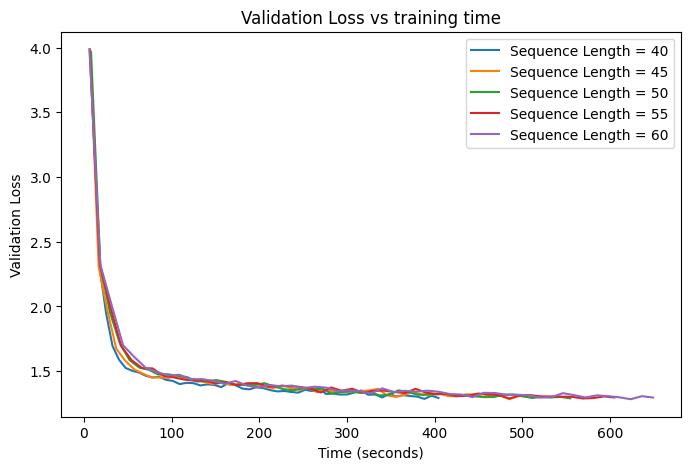

In [ ]:
plt.figure(figsize=(8,5))

for i in range(0, len(T)):
    plt.plot(val_time_all[i], val_loss_all[i], label = f"Sequence Length = {T[i]}")

plt.xlabel("Time (seconds)")
plt.ylabel("Validation Loss")
plt.title("Validation Loss vs training time")
plt.legend(loc='upper right')

plt.show()

In [ ]:
for i in range(0, len(T)):
    string = f"""
    Trained on sequence lengths of {T[i]}:
    Final validation loss: {val_loss_all[i][-1]}
    Total Training Time: {val_time_all[i][-1]}
    Minimum validation loss: {min(val_loss_all[i])} attained at {val_time_all[i][val_loss_all[i].index(min(val_loss_all[i]))]} seconds
    """
    print(string)


    Trained on sequence lengths of 40:
    Final validation loss: 1.292454719543457
    Total Training Time: 404.21971249580383
    Minimum validation loss: 1.2853143215179443 attained at 388.2426335811615 seconds
    

    Trained on sequence lengths of 45:
    Final validation loss: 1.3103899955749512
    Total Training Time: 505.19959831237793
    Minimum validation loss: 1.2830181121826172 attained at 485.23430156707764 seconds
    

    Trained on sequence lengths of 50:
    Final validation loss: 1.2896363735198975
    Total Training Time: 554.6285374164581
    Minimum validation loss: 1.2896363735198975 attained at 554.6285374164581 seconds
    

    Trained on sequence lengths of 55:
    Final validation loss: 1.2966766357421875
    Total Training Time: 604.8954713344574
    Minimum validation loss: 1.288197636604309 attained at 485.05734372138977 seconds
    

    Trained on sequence lengths of 60:
    Final validation loss: 1.2959110736846924
    Total Training Time: 649.085

### **Evaluation**

The best L value for the model to condition on is 45. This is due to the results above showing that 45, between 40 and 50, has lower minimum validation losses compared to the others.

From phase 1, it is also evident that a value around this range is optimal for performance while also having a **shorter training time**.

## **Computing constraints**

**Training time** will be the main constraint here.

To date, there are many features that can improve model performance, but also increase training time significantly, namely:
- Hidden size (from 256 to 512)
- Number of layers (from 4 to 8)
- Batch size (by doubling the size)
- L itself
- Number of iterations (which in turn increases the number of epochs in learning, which means the number of complete passes the model has over all data)
- MLP ratio (by increasing beyond 4)
- And even dataset size (keep in mind that for final training, the entire training set, including validation set will be used for training)

Increasing some of these values will be adopted to produce the final model for training.

## **Decision**

L will be fixed for obvious reasons. MLP ratio will also be fixed as increasing it has insignificant effect on model performance.

For a time constraint under 2 hours, supplied with a larger data set for training, analyzing previous experiments, and noting that there were diminishing returns when data set size is doubled from 40_000_000 tokens to 80_000_000 tokens, **hidden size will be doubled from 256 to 512** to increase model capacity to capture more information in the data, which was restricted when a smaller hidden size is used.

As doubling hidden size greatly increases training time, the only other consideration is for **batch size to double from 64 to 128**. This improves training efficiency as the model is now exposed to more sampling sequences in parallel during training.

These two considerations will be implemented for the final training.



In [ ]:
d_model = 512
L = 45
batch_size = 128

Report the accuracy as a percentage of correct predictions when predicting the next character given the previous L characters.



In [ ]:
# Initialize the model architecture and params
model, params = create_train_state(key, vocab_size, d_model, n_layers,
                                    n_heads, max_len, activation, mlp_ratio, dropout
                                    )

# Warmup
warmup = optax.linear_schedule(
    init_value = 0.0,
    end_value = lr,
    transition_steps = 1_000
    )

# cosine decay after warmup
cos_decay = optax.cosine_decay_schedule(
    init_value = lr,
    decay_steps=20_000,
    alpha = 0.0
    )

schedule = optax.join_schedules(
    schedules=[warmup, cos_decay],
    boundaries=[1_000]
    )

tx = optax.chain(
    optax.clip_by_global_norm(0.5),
    optax.lion(learning_rate = schedule)
    )

# Initialize optimizer state for current params
opt_state = tx.init(params)

niter = 50_000
B_seq, B_tok = batch_size, L
loss_history = []
time_history = []
time_test_history = []
loss_test_history = []
acc_over_all = []
acc_last_all = []
time_start = time.time()

for it in range(niter):
    batch = get_batch(train_text_int, B_seq, B_tok)
    input, target = batch[0], batch[1]
    params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx)

    # update model weights and optimizer state
    params = params_new
    opt_state = opt_state_new
    loss = metrics['loss']

    # Keep track of the training loss and time
    loss_history.append(loss)
    time_history.append(time.time() - time_start)

    # Evaluate on test data periodically
    if it % (niter // 50) == 0 or it == niter - 1:
        time_since_start = time.time() - time_start

        # Training accuracies
        acc, acc_last = metrics['acc'], metrics['acc_last']

        B_test, T_test = 1024, 32
        test_batch = get_batch(test_text_int, B_test, T_test)
        test_input, test_target = test_batch[0], test_batch[1]
        test_logits = model.apply({"params": params}, test_input)
        test_loss, test_metrics = loss_and_metrics(test_logits, test_target)

        # Test accuracies
        test_acc, test_acc_last = test_metrics['acc'], test_metrics['acc_last']

        # Save the accuracies on the test result
        acc_over_all.append(test_acc)
        acc_last_all.append(test_acc_last)

        # Save the loss on test result
        loss_test_history.append(test_loss)
        time_test_history.append(time_since_start)

        # For each period
        print(f"iteration {it:_} Time: {time_since_start:.1f} seconds")
        print(f"\t \t loss(train :: test): {loss:.4f} :: {test_loss:.4f}")
        print(f"\t \t accuracy (train :: test): {100*acc:.1f}% :: {100*test_acc:.1f}%")
        print(f"\t \t accuracy (last character) (train :: test): {100*acc_last:.1f}% :: {100*test_acc_last:.1f}%")
        print()

iteration 0 Time: 5.1 seconds
	 	 loss(train :: test): 3.6575 :: 3.6762
	 	 accuracy (train :: test): 4.3% :: 4.0%
	 	 accuracy (last character) (train :: test): 4.7% :: 3.1%

iteration 1_000 Time: 145.7 seconds
	 	 loss(train :: test): 1.5214 :: 1.5669
	 	 accuracy (train :: test): 52.9% :: 52.0%
	 	 accuracy (last character) (train :: test): 55.5% :: 55.1%

iteration 2_000 Time: 287.1 seconds
	 	 loss(train :: test): 1.4060 :: 1.4299
	 	 accuracy (train :: test): 56.1% :: 56.0%
	 	 accuracy (last character) (train :: test): 57.0% :: 58.5%

iteration 3_000 Time: 428.6 seconds
	 	 loss(train :: test): 1.3239 :: 1.3981
	 	 accuracy (train :: test): 58.6% :: 56.3%
	 	 accuracy (last character) (train :: test): 58.6% :: 58.7%

iteration 4_000 Time: 570.1 seconds
	 	 loss(train :: test): 1.3310 :: 1.3466
	 	 accuracy (train :: test): 58.6% :: 58.0%
	 	 accuracy (last character) (train :: test): 68.8% :: 58.9%

iteration 5_000 Time: 711.4 seconds
	 	 loss(train :: test): 1.3190 :: 1.3442
	 

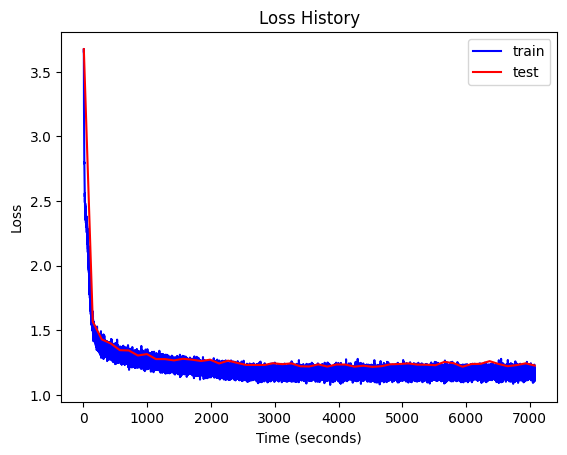

In [ ]:
# Plot the loss history (training vs test)
plt.plot(time_history, loss_history, '-', label='train', color="blue")
plt.plot(time_test_history, loss_test_history, '-', label='test', color="red")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title("Loss History")
plt.show()

It appears that there is poor generalization of test data.

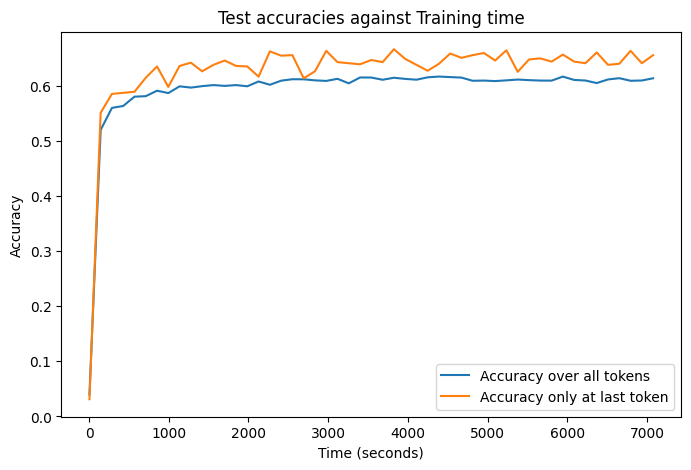

In [ ]:
# Plot the last token accuracy and accuracy over all tokens
plt.figure(figsize=(8,5))

plt.plot(time_test_history, acc_over_all, label = f"Accuracy over all tokens")
plt.plot(time_test_history, acc_last_all, label = f"Accuracy only at last token")

plt.xlabel("Time (seconds)")
plt.ylabel("Accuracy")
plt.title("Test accuracies against Training time")
plt.legend(loc='lower right')

plt.show()

In [ ]:
# Total training time
training_seconds = time_test_history[-1]
string = f"""
    Total time elapsed in seconds: {training_seconds}
    Total time elapsed: {training_seconds//3600} hours, {(training_seconds%3600)//60} minutes and {training_seconds%60} seconds
    """
print(string)


    Total time elapsed in seconds: 7077.434836626053
    Total time elapsed: 1.0 hours, 57.0 minutes and 57.434836626052856 seconds
    


### **Conclusion and reflection**

Total training takes place just under 2 hours. While general performance of the model is not as "ideal" as it may be, it is the journey taken to reach this stage that is most rewarding. Prior to this assignment, I came in with barely any knowledge about transformers, optimizers and training procedures. Now, I can work further on this project in future as a learning journey (RoPE was only partially implemented), and implement other machine learning models such as LSTMs and Markov Chains, both of which I initially wanted to implement in this assignment, but never found the time to do so.

It has been a joy conducting many small-scale experiments. No doubt this is only scratching the tip of the iceberg; it is a small part of a large range of possible model/training improvements, but it is a good way to get started on machine learning.

